## Robot Emotion Classification using Machine Learning models in Tele-Operated Robots

Name: Bhuvaneshwari Ramakrishnan

GUID: 2647486R

This project explores the possibility of tele-operated robots mimicking human emotions when handled remotely. 4 different machine learning models are created for the same - KNN, SVM, Random Forest, MLP

Importing the necessary libraries

In [2]:
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import torch
import pandas as pd
import math


use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

### Data Pre-Processing

Before training the model with the data gathered, the data needs to be segmented according to the task - i.e, writing "8". 

This is necessary because, the participants who handled the robot are not trained to work in that scenario and hence there were some instances where there were unnecessary jerks and movement which was not related to the specified task.

Reading the files to be segmented

In [4]:
#fetch the path from the drive 
path = "/content/drive/MyDrive/Emotion_Dataset/Robot/Happy/User5_happy_ur3e.csv"

#create dataframe from the csv
User5_happy_df = pd.read_csv(path)
User5_happy_df.describe()

,time,x,y,z,qx,qy,qz,qw
count,1.004000e+04,10040.000000,10040.000000,10040.000000,10040.000000,10040.000000,10040.000000,10040.000000
mean,1.658334e+09,0.450796,0.201399,0.434312,0.484131,0.497970,0.539868,0.474881
std,2.898443e+01,0.028243,0.073196,0.095478,0.014566,0.011219,0.012421,0.013467
min,1.658334e+09,0.387736,0.050019,0.275445,0.442854,0.472430,0.514181,0.432156
25%,1.658334e+09,0.428728,0.144384,0.346052,0.476731,0.490137,0.529307,0.464997
50%,1.658334e+09,0.455680,0.193605,0.430843,0.486183,0.496909,0.540598,0.475951
75%,1.658334e+09,0.475068,0.262753,0.530279,0.494681,0.505642,0.549643,0.484414
max,1.658334e+09,0.499138,0.366980,0.590583,0.514399,0.528529,0.565919,0.516276


In order to segment this data, identification of the start and stop coordinates of individual "8" is necessary. This can be achieved by using 1D graphs.

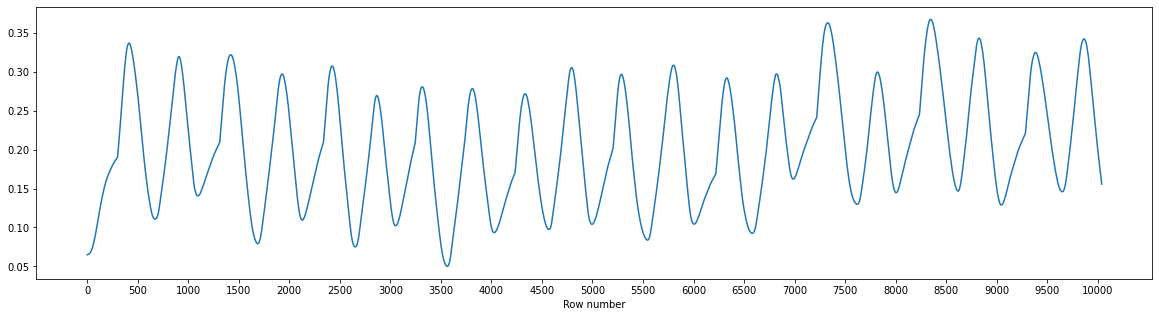

In [6]:
#get the values of column "x" from dataframe
X = User5_happy_df.iloc[:, 1] 
#get the values of column "y" from dataframe
Y = User5_happy_df.iloc[:, 2]

#Plot graph of either of the axis to obtain 1D graph
plt.figure(figsize=(20,5)) 
plt.plot(Y, data=Y)
plt.xlabel('Row number')
plt.xticks(range(0,len(Y),500))
plt.show()

From the above graph, the X-axis denotes the row number, this can be used to identify the row number from the individual "8" has started and finished.

Using this information, a 3D graph can be plotted to visualize the letter "8" and get the exact row count.

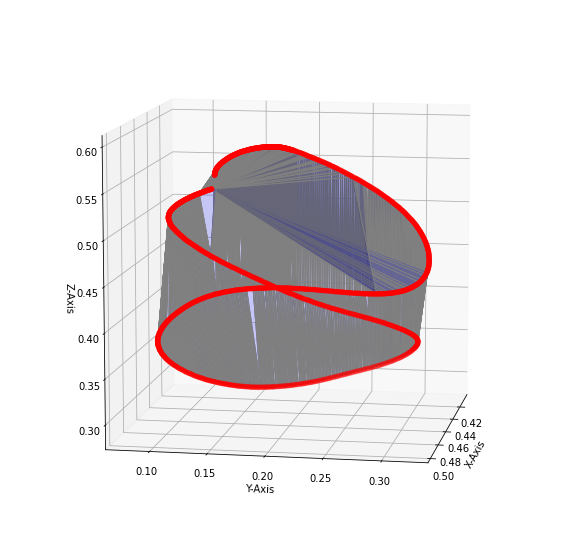

In [10]:
# Get the x,y,z values from the data frame according to the row numbers from the 1D graph
X = User5_happy_df.iloc[1100:2225, 1] 
Y = User5_happy_df.iloc[1100:2225, 2] 
Z = User5_happy_df.iloc[1100:2225, 3]

# Plot the graph using the 3 coordinate values
fig = plt.figure(figsize=(10,10)) 
ax = fig.add_subplot(111, projection='3d') 
ax.plot_trisurf(X, Y, Z, color='blue', edgecolors='grey', alpha=0.2) 
ax.scatter(X, Y, Z, c='red') 
ax.view_init(10, 10)
ax.set_xlabel("X-Axis")
ax.set_ylabel("Y-Axis")
ax.set_zlabel("Z-Axis")
plt.show()

### Feature Extraction

To train the model, features need to be extracted from the raw data. The following different functions extract each feature from the dataframe being passed. Each of these statistical features helps in classifying the emotions easier.

**Normalize function** -  Normalize the data in the dataframe. This helps to understand the features better and how one emotion differs from another.

In [ ]:
def normalise_df(df):
  norm_df=(df-df.min())/(df.max()-df.min())
  return norm_df

**Speed Calculation**

Speed is calculated as the diff() of all the coordinates separately.

diff() - data at (i+1) - data at (i) with respect to time at column 1

In [ ]:
def speed_calculation(df):
  dist_x_val = df.diff().fillna(0.).x
  #create a column in dataframe to store speed_x
  df['speed_x'] = dist_x_val

  dist_y_val = df.diff().fillna(0.).y
  #create a column in dataframe to store speed_y
  df['speed_y'] = dist_y_val

  dist_z_val = df.diff().fillna(0.).z
  #create a column in dataframe to store speed_z
  df['speed_z'] = dist_z_val
  
  return df

**Acceleration Calculation**

Acceleration is calculated as the diff of speed.

In [ ]:
def calculate_acceleration(df):
  acc_x_val = df.diff().fillna(0.).speed_x
  #create a column in dataframe to store acceleration_x
  df['acceleration_x'] = acc_x_val

  acc_y_val = df.diff().fillna(0.).speed_y
  #create a column in dataframe to store acceleration_y
  df['acceleration_y'] = acc_y_val

  acc_z_val = df.diff().fillna(0.).speed_z
  #create a column in dataframe to store acceleration_z
  df['acceleration_z'] = acc_z_val
  
  return df

**Jerk Calculation**

Jerk is calculated as the diff of acceleration

In [ ]:
def calculate_jerk(df):
  jerk_x_val = df.diff().fillna(0.).acceleration_x
  #create a column in dataframe to store jerk_x
  df['jerk_x'] = jerk_x_val

  jerk_y_val = df.diff().fillna(0.).acceleration_y
  #create a column in dataframe to store jerk_y
  df['jerk_y'] = jerk_y_val

  jerk_z_val = df.diff().fillna(0.).acceleration_z
  #create a column in dataframe to store jerk_z
  df['jerk_z'] = jerk_z_val
  
  return df

**Angle Calculation**

Angle is calculated tan of the coordinates.

angle between x and y = tan(y/x)

In [ ]:
def calculate_angle(df):
  tan_xy_val=[]
  tan_yz_val=[]
  tan_zx_val=[]

  # for every row in dataframe, calculating the angle and storing in list
  for index, row in df.iterrows():
    tan_xy_val.append(math.tan(df.y[index]/df.x[index]))
    tan_yz_val.append(math.tan(df.z[index]/df.y[index]))
    tan_zx_val.append(math.tan(df.x[index]/df.z[index]))

  #Storing them as separate columns in dataframe  
  df['tan_xy'] = tan_xy_val
  df['tan_yz'] = tan_yz_val
  df['tan_zx'] = tan_zx_val
  return df

**Feature Calculation**

Function that calculates the above mentioned features for the dataframe passed.

In [ ]:
def feature_calculation(df):

  #Calling the above defined functions by passing the dataframe as parameter
  df=speed_calculation(df)
  df=calculate_acceleration(df)
  df=calculate_jerk(df)
  df=calculate_angle(df)
  
  df_list=[]

  #Calculating the mean of speed for each coordinate
  x_speed_mean_val= df['speed_x'].mean()
  y_speed_mean_val= df['speed_y'].mean()
  z_speed_mean_val = df['speed_z'].mean()

  #Calculating the standard deviation of speed for each coordinate
  x_speed_std_val = df['speed_x'].std()
  y_speed_std_val = df['speed_y'].std()
  z_speed_std_val = df['speed_z'].std()

  #Calculating the variance of speed for each coordinate
  x_speed_var_val = df['speed_x'].var()
  y_speed_var_val = df['speed_y'].var()
  z_speed_var_val = df['speed_z'].var()

  #Calculating the mean of acceleration for each coordinate
  x_acc_mean = df['acceleration_x'].mean()
  y_acc_mean = df['acceleration_y'].mean()
  z_acc_mean = df['acceleration_z'].mean()

  #Calculating the standard deviation of acceleration for each coordinate
  x_acc_std_val = df['acceleration_x'].std()
  y_acc_std_val = df['acceleration_y'].std()
  z_acc_std_val = df['acceleration_z'].std()

  #Calculating the variance of acceleration for each coordinate
  x_acc_var_val = df['acceleration_x'].var()
  y_acc_var_val = df['acceleration_y'].var()
  z_acc_var_val = df['acceleration_z'].var()

  #Calculating the mean of jerk for each coordinate
  x_jerk_mean = df['jerk_x'].mean()
  y_jerk_mean = df['jerk_y'].mean()
  z_jerk_mean = df['jerk_z'].mean()

  #Calculating the standard deviation of jerk for each coordinate
  x_jerk_std_val = df['jerk_x'].std()
  y_jerk_std_val = df['jerk_y'].std()
  z_jerk_std_val = df['jerk_z'].std()

  #Calculating the variance of jerk for each coordinate
  x_jerk_var_val = df['jerk_x'].var()
  y_jerk_var_val = df['jerk_y'].var()
  z_jerk_var_val = df['jerk_z'].var()

  #Calculating the mean of angle for each coordinate
  xy_angle_mean = df['tan_xy'].mean()
  yz_angle_mean = df['tan_yz'].mean()
  zx_angle_mean = df['tan_zx'].mean()

  #Calculating the standard deviation of angle for each coordinate
  xy_angle_std_val = df['tan_xy'].std()
  yz_angle_std_val = df['tan_yz'].std()
  zx_angle_std_val = df['tan_zx'].std()

  #Calculating the variance of angle for each coordinate
  xy_angle_var_val = df['tan_xy'].var()
  yz_angle_var_val = df['tan_yz'].var()
  zx_angle_var_val = df['tan_zx'].var()

  #Calculating the range of all coordinates
  x_range_val = df['x'].max()-df['x'].min()
  y_range_val = df['y'].max()-df['y'].min()
  z_range_val = df['z'].max()-df['z'].min()
  
  #Calculating the time taken to do a single task "8"
  time_taken_val = df.iloc[-1,0] - df.iloc[-len(df)+1,0]
  
  #Adding all the values calculated into listand returning the list
  df_list=[x_speed_mean_val,y_speed_mean_val,z_speed_mean_val,
           x_speed_std_val,y_speed_std_val,z_speed_std_val,
           x_speed_var_val,y_speed_var_val,z_speed_var_val,
           x_acc_mean,y_acc_mean,z_acc_mean,
           x_acc_std_val,y_acc_std_val,z_acc_std_val,
           x_acc_var_val,y_acc_var_val,z_acc_var_val,
           x_jerk_mean,y_jerk_mean,z_jerk_mean,
           x_jerk_std_val,y_jerk_std_val,z_jerk_std_val,
           x_jerk_var_val,y_jerk_var_val,z_jerk_var_val,
           xy_angle_mean,yz_angle_mean,zx_angle_mean,
           xy_angle_std_val,yz_angle_std_val,zx_angle_std_val,
           xy_angle_var_val,yz_angle_var_val,zx_angle_var_val,
           x_range_val,y_range_val,z_range_val,
           time_taken_val]
  
  return df_list

**Path Collection**

Collection of all files for all emotions from 8 participants.

Storing it in list for ease of access

In [ ]:
entirePathList=[[
    
    #Files for happy emotion
    '/content/drive/MyDrive/Emotion_Dataset/Robot/Happy/segmented/User1_segmented_robot_happy.xlsx',
    '/content/drive/MyDrive/Emotion_Dataset/Robot/Happy/segmented/User2_segmented_robot_happy.xlsx',
    '/content/drive/MyDrive/Emotion_Dataset/Robot/Happy/segmented/User3_segmented_robot_happy.xlsx',
    '/content/drive/MyDrive/Emotion_Dataset/Robot/Happy/segmented/User4_segmented_robot_happy.xlsx',
    '/content/drive/MyDrive/Emotion_Dataset/Robot/Happy/segmented/User5_segmented_robot_happy.xlsx',
    '/content/drive/MyDrive/Emotion_Dataset/Robot/Happy/segmented/User6_segmented_robot_happy.xlsx',
    '/content/drive/MyDrive/Emotion_Dataset/Robot/Happy/segmented/User7_segmented_robot_happy.xlsx',
    '/content/drive/MyDrive/Emotion_Dataset/Robot/Happy/segmented/User8_segmented_robot_happy.xlsx'
    ],

    #Files for sad emotion
    ['/content/drive/MyDrive/Emotion_Dataset/Robot/Sad/segmented/User1_segmented_robot_sad.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Sad/segmented/User2_segmented_robot_sad.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Sad/segmented/User3_segmented_robot_sad.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Sad/segmented/User4_segmented_robot_sad.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Sad/segmented/User5_segmented_robot_sad.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Sad/segmented/User6_segmented_robot_sad.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Sad/segmented/User7_segmented_robot_sad.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Sad/segmented/User8_segmented_robot_sad.xlsx'
    ],

    #Files for angry emotion
    [
      '/content/drive/MyDrive/Emotion_Dataset/Robot/Angry/segmented/User1_segmented_robot_angry.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Angry/segmented/User2_segmented_robot_angry.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Angry/segmented/User3_segmented_robot_angry.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Angry/segmented/User4_segmented_robot_angry.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Angry/segmented/User5_segmented_robot_angry.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Angry/segmented/User6_segmented_robot_angry.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Angry/segmented/User7_segmented_robot_angry.xlsx',
     '/content/drive/MyDrive/Emotion_Dataset/Robot/Angry/segmented/User8_segmented_robot_angry.xlsx'
     ],

     #Files for fear emotion
     [
      '/content/drive/MyDrive/Emotion_Dataset/Robot/Fear/segmented/User1_segmented_robot_fear.xlsx',
      '/content/drive/MyDrive/Emotion_Dataset/Robot/Fear/segmented/User2_segmented_robot_fear.xlsx',
      '/content/drive/MyDrive/Emotion_Dataset/Robot/Fear/segmented/User3_segmented_robot_fear.xlsx',
      '/content/drive/MyDrive/Emotion_Dataset/Robot/Fear/segmented/User4_segmented_robot_fear.xlsx',
      '/content/drive/MyDrive/Emotion_Dataset/Robot/Fear/segmented/User5_segmented_robot_fear.xlsx',
      '/content/drive/MyDrive/Emotion_Dataset/Robot/Fear/segmented/User6_segmented_robot_fear.xlsx',
      '/content/drive/MyDrive/Emotion_Dataset/Robot/Fear/segmented/User7_segmented_robot_fear.xlsx',
      '/content/drive/MyDrive/Emotion_Dataset/Robot/Fear/segmented/User8_segmented_robot_fear.xlsx'
    ]
]

Logic to take the Path and convert to Dataframe.

After converting to Dataframe,  the features are calculated by calling the feature calculation function and storing the values in a list.

In [ ]:
seg_list=[]
seg_df=pd.DataFrame()

#Looping through Pathlist
for pathList in entirePathList:

  # Retrieving label name from path to store the label in dataframe
  label = pathList[0].split('/')[-3]

  #Looping through each path
  for path in pathList:
    s_df=pd.read_excel(path)

    #removing index which has null values from the segmented file
    index=s_df[s_df.isnull().all(axis=1)].index.tolist()
    index.insert(0,0)

    #from the null index list obtained calling the feature calculation function for each individual "8"
    for i in range(len(index)-1):
      seg_df=s_df.iloc[index[i]:index[i+1],:]
      res = feature_calculation(seg_df)
      res.append(label)
      seg_list.append(res)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

Storing the feature list into a dataframe for ease of access

In [ ]:
robot_df = pd.DataFrame(seg_list,columns=['speed_x_mean','speed_y_mean','speed_z_mean',
                                         'speed_x_std','speed_y_std','speed_z_std',
                                         'speed_x_var','speed_y_var','speed_z_var',
                                         'acceleration_x_mean','acceleration_y_mean','acceleration_z_mean',
                                         'acceleration_x_std','acceleration_y_std','acceleration_z_std',
                                         'acceleration_x_var','acceleration_y_var','acceleration_z_var',
                                         'jerk_x_mean','jerk_y_mean','jerk_z_mean',
                                         'jerk_x_std','jerk_y_std','jerk_z_std',
                                         'jerk_x_var','jerk_y_var','jerk_z_var',
                                         'angle_xy_mean','angle_yz_mean','angle_zx_mean',
                                         'angle_xy_std','angle_yz_std','angle_zx_std',
                                         'angle_xy_var','angle_yz_var','angle_zx_var',
                                         'x_range','y_range','z_range','time_range',
                                         'label'
                                  ])
robot_df

,speed_x_mean,speed_y_mean,speed_z_mean,speed_x_std,speed_y_std,speed_z_std,speed_x_var,speed_y_var,speed_z_var,acceleration_x_mean,...,angle_yz_std,angle_zx_std,angle_xy_var,angle_yz_var,angle_zx_var,x_range,y_range,z_range,time_range,label
0,-0.000018,0.000006,-0.000006,0.000143,0.000767,0.000425,2.046654e-08,5.889238e-07,1.808420e-07,1.601237e-07,...,57.754354,3668.821049,0.020147,3335.565401,1.346025e+07,0.078238,0.205689,0.212325,12.47993,Happy
1,0.000039,0.000115,0.000005,0.000186,0.001015,0.000474,3.472353e-08,1.030719e-06,2.250015e-07,1.391333e-07,...,43.876062,5.564966,0.019842,1925.108845,3.096885e+01,0.083850,0.197962,0.205781,10.98958,Happy
2,-0.000006,0.000060,0.000010,0.000146,0.001152,0.000569,2.131901e-08,1.327582e-06,3.242955e-07,-1.273624e-07,...,158.237447,61.591953,0.018491,25039.089581,3.793569e+03,0.052415,0.209977,0.212985,8.49040,Happy
3,0.000042,0.000025,-0.000070,0.000221,0.001125,0.000475,4.885557e-08,1.264554e-06,2.255811e-07,-1.263147e-07,...,77.753566,381.661958,0.030630,6045.617065,1.456659e+05,0.109725,0.284346,0.245004,10.99058,Happy
4,-0.000004,0.000053,-0.000019,0.000238,0.001095,0.000578,5.653885e-08,1.199731e-06,3.335645e-07,-3.177367e-07,...,6.498067,85.679932,0.014818,42.224881,7.341051e+03,0.089460,0.196203,0.204642,8.49008,Happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,-0.000004,0.000088,0.000100,0.000494,0.000938,0.000697,2.437026e-07,8.805309e-07,4.854011e-07,-1.432119e-07,...,33.102942,189.465090,0.014892,1095.804794,3.589702e+04,0.107145,0.156517,0.200133,7.99022,Fear
448,-0.000069,0.000114,0.000041,0.000584,0.001122,0.000874,3.413960e-07,1.258801e-06,7.644002e-07,-1.773921e-06,...,19.064766,112.737244,0.009568,363.465296,1.270969e+04,0.093357,0.152284,0.238752,5.98966,Fear
449,-0.000055,0.000055,-0.000076,0.000607,0.001000,0.000773,3.687023e-07,1.000810e-06,5.974740e-07,-1.407527e-07,...,78.392366,4.661308,0.018698,6145.363001,2.172779e+01,0.126447,0.172537,0.229113,6.99053,Fear
450,0.000085,-0.000071,0.000034,0.000460,0.001028,0.000684,2.117570e-07,1.056952e-06,4.685293e-07,5.304733e-07,...,38.444431,1.735217,0.013886,1477.974283,3.010976e+00,0.098288,0.185863,0.182176,5.98995,Fear


Normalising the dataframe which was created after calculating the features

In [ ]:
# Storing the values of dataframe as temp to remove the label column and normalising it
temp = normalise_df(robot_df.iloc[:,:-1])

In [ ]:
# Adding the label back to the dataframe after normalising
temp['label']=robot_df['label']
robot_df=temp
robot_df

,speed_x_mean,speed_y_mean,speed_z_mean,speed_x_std,speed_y_std,speed_z_std,speed_x_var,speed_y_var,speed_z_var,acceleration_x_mean,...,angle_yz_std,angle_zx_std,angle_xy_var,angle_yz_var,angle_zx_var,x_range,y_range,z_range,time_range,label
0,0.556578,0.552057,0.514894,0.130929,0.422698,0.228115,0.033725,0.278079,0.117960,0.634645,...,0.003368,0.756304,3.752614e-08,1.177840e-05,5.720003e-01,0.381103,0.520779,0.374957,0.655869,Happy
1,0.782641,0.793096,0.546968,0.196346,0.670193,0.288987,0.061547,0.539198,0.160442,0.629857,...,0.002544,0.001134,3.694148e-08,6.796111e-06,1.315873e-06,0.411809,0.495999,0.357224,0.562698,Happy
2,0.604435,0.672509,0.559413,0.135386,0.806972,0.406950,0.035389,0.714657,0.255966,0.569069,...,0.009341,0.012684,3.435446e-08,8.844385e-05,1.612095e-04,0.239818,0.534533,0.376747,0.406459,Happy
3,0.793673,0.594322,0.329480,0.248778,0.779326,0.289744,0.089126,0.677405,0.161000,0.569308,...,0.004557,0.078666,5.760615e-08,2.135138e-05,6.190146e-03,0.553378,0.773047,0.463515,0.562761,Happy
4,0.612487,0.655441,0.475300,0.274088,0.750163,0.416971,0.104120,0.639091,0.264883,0.525644,...,0.000322,0.017650,2.731867e-08,1.450188e-07,3.119616e-04,0.442502,0.490357,0.354136,0.406439,Happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,0.614737,0.734163,0.821202,0.660837,0.593419,0.564733,0.469370,0.450431,0.410954,0.565454,...,0.001903,0.039045,2.745978e-08,3.866680e-06,1.525463e-03,0.539263,0.363077,0.341919,0.375189,Fear
448,0.358286,0.792338,0.651333,0.797816,0.776768,0.784959,0.660018,0.674004,0.679358,0.193487,...,0.001069,0.023228,1.726272e-08,1.279767e-06,5.401046e-04,0.463823,0.349502,0.446573,0.250122,Fear
449,0.411661,0.659773,0.310148,0.832454,0.655374,0.659297,0.713306,0.521521,0.518771,0.566015,...,0.004595,0.000948,3.475138e-08,2.170372e-05,9.231695e-07,0.644867,0.414456,0.420453,0.312693,Fear
450,0.963481,0.380639,0.630669,0.610217,0.683013,0.549585,0.407028,0.554703,0.394723,0.719122,...,0.002221,0.000345,2.553394e-08,5.216654e-06,1.277886e-07,0.490802,0.457196,0.293255,0.250140,Fear


From the above dataframe, it can be seen that, the final dataframe has 452 rows, which includes the features of the individual tasks "8". This data can be used to train the model and classify emotions.

### Model

In [ ]:
#Storing the dataframe into csv file
robot_df.to_csv('/content/drive/MyDrive/Emotion_Dataset/Robot/robot_full_data.csv')

In [ ]:
#accessing the saved file and reading as dataframe
robot_data_df=pd.read_csv('/content/drive/MyDrive/Emotion_Dataset/Robot/robot_full_data.csv')

Importing necessary libraries for Model training

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [ ]:
#Removing the first column as it just contains index values
robot_data_df = robot_data_df.iloc[:,1:]
robot_data_df

,speed_x_mean,speed_y_mean,speed_z_mean,speed_x_std,speed_y_std,speed_z_std,speed_x_var,speed_y_var,speed_z_var,acceleration_x_mean,...,angle_yz_std,angle_zx_std,angle_xy_var,angle_yz_var,angle_zx_var,x_range,y_range,z_range,time_range,label
0,0.556578,0.552057,0.514894,0.130929,0.422698,0.228115,0.033725,0.278079,0.117960,0.634645,...,0.003368,0.756304,3.752614e-08,1.177840e-05,5.720003e-01,0.381103,0.520779,0.374957,0.655869,Happy
1,0.782641,0.793096,0.546968,0.196346,0.670193,0.288987,0.061547,0.539198,0.160442,0.629857,...,0.002544,0.001134,3.694148e-08,6.796111e-06,1.315873e-06,0.411809,0.495999,0.357224,0.562698,Happy
2,0.604435,0.672509,0.559413,0.135386,0.806972,0.406950,0.035389,0.714657,0.255966,0.569069,...,0.009341,0.012684,3.435446e-08,8.844385e-05,1.612095e-04,0.239818,0.534533,0.376747,0.406459,Happy
3,0.793673,0.594322,0.329480,0.248778,0.779326,0.289744,0.089126,0.677405,0.161000,0.569308,...,0.004557,0.078666,5.760615e-08,2.135138e-05,6.190146e-03,0.553378,0.773047,0.463515,0.562761,Happy
4,0.612487,0.655441,0.475300,0.274088,0.750163,0.416971,0.104120,0.639091,0.264883,0.525644,...,0.000322,0.017650,2.731867e-08,1.450188e-07,3.119616e-04,0.442502,0.490357,0.354136,0.406439,Happy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447,0.614737,0.734163,0.821202,0.660837,0.593419,0.564733,0.469370,0.450431,0.410954,0.565454,...,0.001903,0.039045,2.745978e-08,3.866680e-06,1.525463e-03,0.539263,0.363077,0.341919,0.375189,Fear
448,0.358286,0.792338,0.651333,0.797816,0.776768,0.784959,0.660018,0.674004,0.679358,0.193487,...,0.001069,0.023228,1.726272e-08,1.279767e-06,5.401046e-04,0.463823,0.349502,0.446573,0.250122,Fear
449,0.411661,0.659773,0.310148,0.832454,0.655374,0.659297,0.713306,0.521521,0.518771,0.566015,...,0.004595,0.000948,3.475138e-08,2.170372e-05,9.231695e-07,0.644867,0.414456,0.420453,0.312693,Fear
450,0.963481,0.380639,0.630669,0.610217,0.683013,0.549585,0.407028,0.554703,0.394723,0.719122,...,0.002221,0.000345,2.553394e-08,5.216654e-06,1.277886e-07,0.490802,0.457196,0.293255,0.250140,Fear


Splitting the data frame into two so that the "x_data" contains all the features required to train the model and "y_data" contains the label

In [ ]:
x_data = robot_data_df.iloc[:,:-1]
y_data = robot_data_df.iloc[:,-1]

Before training any model, a baseline model needs to be created and its accuracy noted, this helps to know how well the other trained models perform with regards to the baseline.


The Baseline model chosen for this dataset is the Dummy classifier.

**Dummy Classifier**

In [ ]:
#importing dummy classifier
from sklearn.dummy import DummyClassifier

Training the dummy classifier and obtaining the accuracy of the predictions made with the model.

In [ ]:
#spliting the x_data and the y_data into train and test of 80%-20%
dummy_x_train,dummy_x_test,dummy_y_train,dummy_y_test = train_test_split(x_data, y_data, train_size=0.80)

#Creating the Dummy classifier
dummy_clf = DummyClassifier(strategy="stratified")

#Training the model with train data and label
dummy_clf.fit(dummy_x_train,dummy_y_train)

#Predicting the labels of test data
dummy_preds=dummy_clf.predict(dummy_x_test)

#Finding accuracy with respect to test labels
dummy_accuracy = sklearn.metrics.accuracy_score(dummy_y_test, dummy_preds)
dummy_accuracy

0.23076923076923078

From the above we have got the baseline accuracy as 23%. The next steps is to create machine learning models that will achieve performance more that the set baseline accuracy.

**Creating Train and Test Data Set**:

Creating the train and test data set from the x_data and y_data to use in all model trainings. The split is made as 80% train data and 20% test data from the entire 452 records data frame. 

The data is split randomly each time the command is done.

In [ ]:
x_train,x_test,y_train,y_test = train_test_split(x_data, y_data, train_size=0.80)

**Analysis of Data**

Once the data is split into train and test data, the data is analysed to see the different counts of records per emotion.

Emotion Data distribution in entire data set

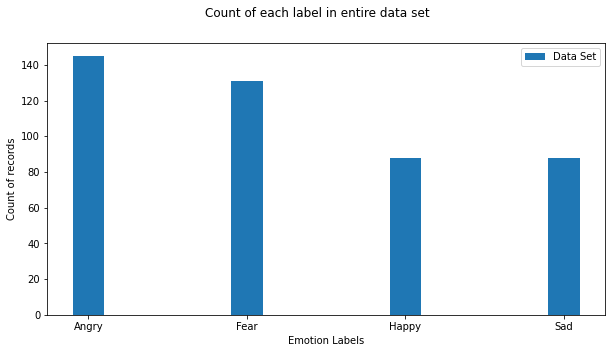

In [ ]:
x_labels = []

#getting the count of records for each emotion from entire data set
count_label = robot_data_df.groupby(by='label')
data_size = count_label.size()
for k,v in count_label:
  x_labels.append(k)

x_axis_len = np.arange(len(count_label))

#plotting a bar chart to represent the count per emotion
plt.figure(figsize=(10,5))
plt.suptitle('Count of each label in entire data set')
plt.xlabel('Emotion Labels')
plt.ylabel('Count of records')
plt.bar(x_axis_len +0.0,data_size,width=0.2,label='Data Set')
plt.xticks(x_axis_len,x_labels)
plt.legend()
plt.show()

In [ ]:
robot_data_df['label'].value_counts()

Angry    145
Fear     131
Happy     88
Sad       88
Name: label, dtype: int64

From above, it can be seen that the number of records per emotion is not the same. Hence the data set is unbalanced. 

This inequality in data can be attributed to the fact that the participants when feelings the emotions of anger and fear, moved in a distorted manner to display their emotion. Hence the speed at which the task was performed increased and hence more number of tasks was performed with these emotions than the other two.

Emotion data distribution in train and test set

In [ ]:
import collections

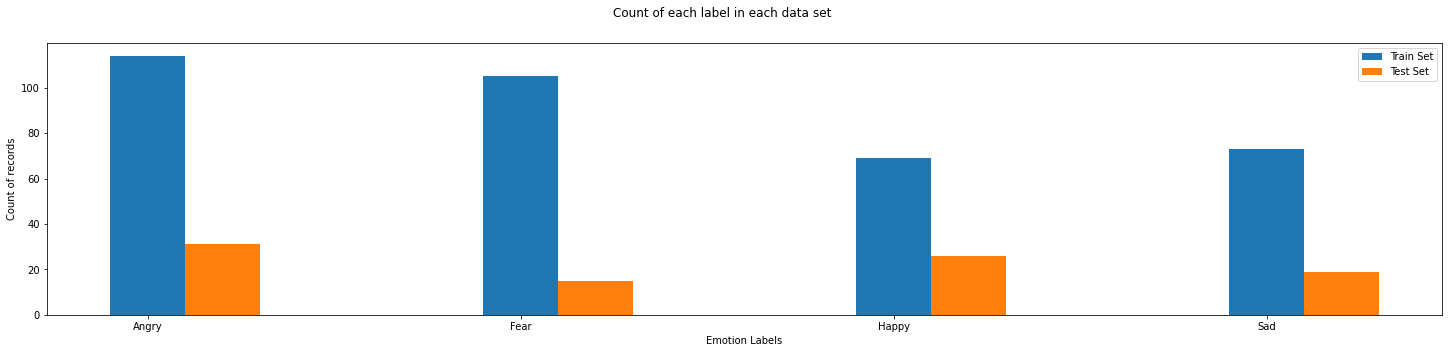

In [ ]:
#using counter to count of individual emotion label count in train and test data set
count_train = collections.Counter(y_train)
count_test = collections.Counter(y_test)

#Plotting a graph based on the counts
plt.figure(figsize=(25,5))
plt.suptitle('Count of each label in each data set')
plt.xlabel('Emotion Labels')
plt.ylabel('Count of records')
plt.bar(np.arange(len(count_train))+0.0,count_train.values(),width=0.2,label='Train Set')
plt.bar(np.arange(len(count_test))+0.2,count_test.values(),width=0.2,label='Test Set')
plt.xticks(x_axis_len,x_labels)
plt.legend()
plt.show()

From the above plot, it can be seen that, similar to the entire data set, the train and test set also have an unbalanced number of records per emotion. 

The number of records for Angry and Fear in the train data set is higher than Happy and Sad. This in a way is useful as the tasks performed by the participants while displaying Angry and Fear emotions varied hugely when compared from one participant to another. 

Hence the model has to be trained more on these two emotions so that the it can learn to classify these emotions better.

**KNN Model**

KNN model is a supervised machine learning model. It is a simple classification model that uses the concept of nearest neighbours and euclidean distance to classify the data into their specific labels.

In order to build a KNN classifier, the value of K needs to be determined. This can be done as follows:

Determining K value

In [ ]:
knn_acc_list = []

#Looping through 15times to train and test the model of knn to determine which value of k gives the better train and Test score
for i in range(1,16,1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train,y_train)
    test_score = knn.score(x_test,y_test)
    train_score = knn.score(x_train,y_train)
    knn_acc_list.append((i, test_score ,train_score))
df = pd.DataFrame(knn_acc_list, columns=['K','Test Score','Train Score'])
print(df)

     K  Test Score  Train Score
0    1    0.692308     1.000000
1    2    0.692308     0.772853
2    3    0.637363     0.775623
3    4    0.637363     0.736842
4    5    0.648352     0.689751
5    6    0.659341     0.700831
6    7    0.648352     0.686981
7    8    0.659341     0.667590
8    9    0.648352     0.670360
9   10    0.670330     0.659280
10  11    0.714286     0.664820
11  12    0.703297     0.634349
12  13    0.681319     0.639889
13  14    0.648352     0.637119
14  15    0.637363     0.639889


From the above it can be seen that, for the value of K=11, the model has a better train and test score. Using this value to build the model will result in a better classifier.

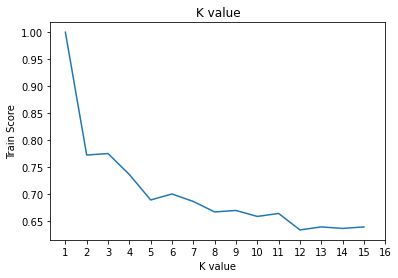

In [ ]:
#Graph to show the graph of the K value for train set
plt.plot(df['K'],df['Train Score'])
plt.title("K value")
plt.xlabel("K value")
plt.xticks(range(1,17))
plt.ylabel("Train Score")
plt.show()

Building the model

In [ ]:
#Training the model based on the K value determined and testing it against the test labels
knn_model = KNeighborsClassifier(n_neighbors=11)
knn_model.fit(x_train,y_train)
knn_predictions = knn_model.predict(x_test)
accuracy = sklearn.metrics.accuracy_score(y_test, knn_predictions)

In [ ]:
accuracy

0.7142857142857143

The KNN Classifier provides an accuracy of **71%** for the train and test data set used.

**SVM Model**

SVM Model is naother supervised learning model. It uses the concept of hyper planes to classify the data.

Inorder to build a better SVM model, the kernel for the SVM needs to be chosen. there are various types of Kernels, but the most common one is the RBF. RBF works well for non linear data set.

In order to train the model in a better way, the values of C and gamma need to be initialised. 

C - regularization parameter (penalty). Obtaining an intermediate value of C results in a better performing model

Gamma - determines the impact of one training record.

To determine the values of C and Gamma, the GridSearch CV was used.

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
#setting the range for C and gamma
C_range = np.logspace(-7, 7, 15)
gamma_range = np.logspace(-7, 7, 15)

In [ ]:
params_grid = dict(gamma=gamma_range, C=C_range)

In [ ]:
#Creating a 7 fold GridSearch CV to determine the best values for the hyper-parameters
grid = GridSearchCV(SVC(kernel='rbf'), param_grid=params_grid, cv=7)
grid.fit(x_train,y_train)

GridSearchCV(cv=7, estimator=SVC(),
             param_grid={'C': array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07]),
                         'gamma': array([1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00,
       1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07])})

In [ ]:
print(
    "The best parameters are %s with a score of %0.2f"
    % (grid.best_params_, grid.best_score_)
)

The best parameters are {'C': 10.0, 'gamma': 1.0} with a score of 0.58


Using the best parameters obtained, the SVM RBF model is trained and tested

In [ ]:
svm_model = SVC(kernel='rbf',gamma=1.0, C=10.0)
svm_model.fit(x_train,y_train)
svm_predictions = svm_model.predict(x_test)
accuracy = sklearn.metrics.accuracy_score(y_test, svm_predictions)
accuracy

0.6263736263736264

The SVM model has accuracy of **63%** for the train and test data being used.

**Random Forest**

The Random forest model is another supervised learning model. This model uses the concepts of decision trees to make predictions of the labels.

The trees are radonly created each time the model is trained hence the accuracy of the model changes for every single run.

The important hyper-parameter associated with this model is the n-estimators.

In [ ]:
#model is trained with 100 n-estimaters and predicted for test labels
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(x_train,y_train)
rf_predictions = rf_model.predict(x_test)
accuracy = sklearn.metrics.accuracy_score(y_test, rf_predictions)
accuracy

0.6813186813186813

The accuracy obtained from the Random forest model is **68%**

**MLP Classifier**

MLP classifiers are Neural Networks. they work well with statistical data and classification and regression type of problems unlike CNN and RNN which require image data and sequential data respectively.

There are various hyper-parameters associated with building a MLP model. the chosen hyper parameters are:

Hidden layer size, initial learning rate, alpha, random state and max_iters.

The values for these parameters are chosen through a 5-fold GridSearch CV

In [ ]:
#A MLP classifier model is created with epoch size 1000
cv_clf=MLPClassifier(max_iter=1000)

The parameters for the Gridsearch CV are set and fitted against the train data to obtain best values for the hyper-parameters

In [ ]:
params = {
    'hidden_layer_sizes' : [(100, 100, 100), (100, 100, 150)], 
    'learning_rate_init' : np.logspace(-2,2,5),
    'alpha' : np.logspace(-2,2,5),
    'random_state': np.arange(1,10,1)
}
mlp_grid = GridSearchCV(cv_clf, params, verbose=1,cv=5)
mlp_grid.fit(x_train, y_train)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


GridSearchCV(cv=5,
             estimator=MLPClassifier(alpha=0.01, max_iter=1000, random_state=1),
             param_grid={'alpha': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'hidden_layer_sizes': [(100, 100, 100),
                                                (100, 100, 150)],
                         'learning_rate_init': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]),
                         'random_state': array([1, 2, 3, 4, 5, 6, 7, 8, 9])},
             verbose=1)

In [ ]:
print('Best Score: ',mlp_grid.best_score_)
print('Best Parameters: ',mlp_grid.best_params_) 

Best Score:  0.5873668188736682
Best Parameters:  {'alpha': 0.01, 'hidden_layer_sizes': (100, 100, 100), 'learning_rate_init': 0.01, 'random_state': 5}


From the best values obtained, the model is trained and tested against the labels.

In [ ]:
clf = MLPClassifier(hidden_layer_sizes=(100,100,100),
                    random_state=5,max_iter=1000,
                    verbose=True,alpha=0.01,
                    learning_rate_init=0.01)

In [ ]:
clf.fit(x_train, y_train)

Iteration 1, loss = 1.49118541
Iteration 2, loss = 1.36939914
Iteration 3, loss = 1.34575448
Iteration 4, loss = 1.32146293
Iteration 5, loss = 1.29706841
Iteration 6, loss = 1.26397035
Iteration 7, loss = 1.24885833
Iteration 8, loss = 1.22597816
Iteration 9, loss = 1.20523716
Iteration 10, loss = 1.19436883
Iteration 11, loss = 1.16486887
Iteration 12, loss = 1.19037329
Iteration 13, loss = 1.15163028
Iteration 14, loss = 1.15237044
Iteration 15, loss = 1.12457791
Iteration 16, loss = 1.11391193
Iteration 17, loss = 1.08229704
Iteration 18, loss = 1.06660301
Iteration 19, loss = 1.05163547
Iteration 20, loss = 1.02330292
Iteration 21, loss = 0.99992931
Iteration 22, loss = 0.98680147
Iteration 23, loss = 0.98746660
Iteration 24, loss = 1.00850148
Iteration 25, loss = 0.95782392
Iteration 26, loss = 0.95941928
Iteration 27, loss = 0.90816982
Iteration 28, loss = 0.88616293
Iteration 29, loss = 0.85747706
Iteration 30, loss = 0.84222543
Iteration 31, loss = 0.83645709
Iteration 32, los

MLPClassifier(alpha=0.01, hidden_layer_sizes=(100, 100, 100),
              learning_rate_init=0.01, max_iter=1000, random_state=5,
              verbose=True)

In [ ]:
clf_pred=clf.predict(x_test)

In [ ]:
accuracy_score(y_test,clf_pred)

0.6483516483516484

The MLP model has an accuracy of **64%** for the train and test data set

### Evaluation

After training the models, they were evaluated against each other to determine the best performing model amongst the 4 chosen models.

Since the accuracy of the KNN model was highest, the number of correctly redicted and incorrectly predicted labels was determined.

Predicted Labels match with actual labels:  65
Predicted labels not match with actual labels:  26


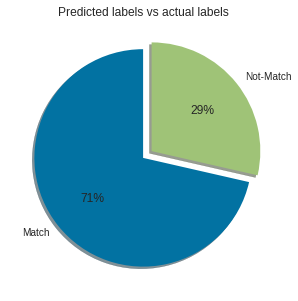

In [ ]:
true_count=0
false_count=0

#get teh count of correctly predicted labels
for i,v in enumerate(y_test):
  if v== knn_predictions[i]:
    true_count+=1
  else:
    false_count+=1
print('Predicted Labels match with actual labels: ',true_count)
print('Predicted labels not match with actual labels: ',false_count)

#Plotting pie chart for the same
value =[true_count,false_count]
labels=['Match','Not-Match']
plt.figure(figsize=(10,5))
plt.pie(value,labels=labels,autopct='%1.0f%%',shadow=True,explode=[0,0.1],startangle=90,)
plt.title('Predicted labels vs actual labels')
plt.show()

To evaluate the models even further, the Confusion matrix, Precison, recall, f1 scores and accuracy was used.

Importing the libraries neccesary to perform evaluation

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import fbeta_score

Creating a function to produce the classification report for the model

In [ ]:
def evaluation_summary(description, true_labels, predictions, target_classes=y_train.unique()):
  return classification_report(true_labels, predictions,  digits=3, zero_division=0, target_names=target_classes, output_dict=True)

Creating Classification Report for every model

Dummy Evaluation

In [ ]:
dummy_eval = evaluation_summary("Dummy Classifier", dummy_y_test, dummy_preds,dummy_y_test.unique())

KNN Evaluation

In [ ]:
knn_eval = evaluation_summary("KNN classification", y_test, knn_predictions,y_test.unique())

SVM Evaluation

In [ ]:
svm_eval = evaluation_summary("SVM classification", y_test, svm_predictions,y_test.unique())

Random Forest

In [ ]:
rf_eval = evaluation_summary("RF classification", y_test, rf_predictions,y_test.unique())

MLP Evaluation

In [ ]:
mlp_eval = evaluation_summary("MLP classification", y_test, clf_pred,y_test.unique())

Combining all evaluations together

In [ ]:
dummy_eval_df=pd.DataFrame.from_dict(dummy_eval)[['Angry','Fear','Happy','Sad','accuracy']][:-1]
knn_eval_df=pd.DataFrame.from_dict(knn_eval)[['Angry','Fear','Happy','Sad','accuracy']][:-1]
svm_eval_df=pd.DataFrame.from_dict(svm_eval)[['Angry','Fear','Happy','Sad','accuracy']][:-1]
rf_eval_df=pd.DataFrame.from_dict(rf_eval)[['Angry','Fear','Happy','Sad','accuracy']][:-1]
mlp_eval_df=pd.DataFrame.from_dict(mlp_eval)[['Angry','Fear','Happy','Sad','accuracy']][:-1]
frames=[dummy_eval_df,knn_eval_df,svm_eval_df,rf_eval_df,mlp_eval_df]
classifier_df = pd.concat(frames,keys=['Dummy','KNN','SVM','RF','MLP'])
classifier_df

Angry      Fear     Happy       Sad  accuracy
Dummy precision  0.423077  0.148148  0.083333  0.285714  0.230769
      recall     0.297297  0.222222  0.117647  0.210526  0.230769
      f1-score   0.349206  0.177778  0.097561  0.242424  0.230769
KNN   precision  0.657895  1.000000  0.720000  0.684211  0.714286
      recall     0.806452  0.600000  0.692308  0.684211  0.714286
      f1-score   0.724638  0.750000  0.705882  0.684211  0.714286
SVM   precision  0.695652  0.450000  0.666667  0.666667  0.626374
      recall     0.516129  0.600000  0.692308  0.736842  0.626374
      f1-score   0.592593  0.514286  0.679245  0.700000  0.626374
RF    precision  0.758621  0.600000  0.666667  0.647059  0.681319
      recall     0.709677  0.600000  0.769231  0.578947  0.681319
      f1-score   0.733333  0.600000  0.714286  0.611111  0.681319
MLP   precision  0.833333  0.526316  0.617647  0.650000  0.648352
      recall     0.483871  0.666667  0.807692  0.684211  0.648352
      f1-score   0.612245  0.588235  0.700000  0.666667  0.648352

The above dataframe gives an overview of the accuracy, precision, recall and F1-scores for each model against each emotion. This helps to determine the performance of the models for each of the label.

Accuracy Graph of all models

<function matplotlib.pyplot.show(*args, **kw)>

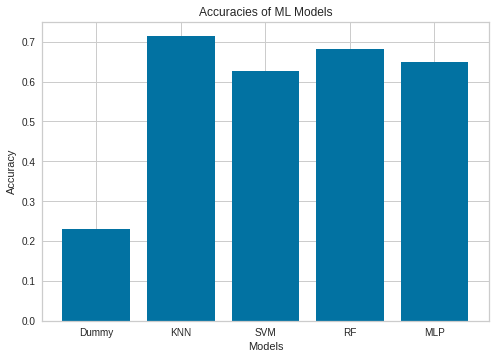

In [ ]:
x_val=[]
y_val=[]
for i in range(len(classifier_df)):
  x_val.append(classifier_df.index[i][0])
  y_val.append(classifier_df['accuracy'][i])

plt.title('Accuracies of ML Models')
plt.bar(x_val,y_val)
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show

The above graph represents the model accuracy. They are as follows:



1.   Baseline accuracy - 23%
2.   KNN - 71%
3.   SVM - 63%
4.   RF - 68%
5.   MLP - 65%



**Confusion Matrix**

Confusion matrix helps to understand how the model has performed against the actual labels and the predicted labels for each emotion.

This is valuable information as it helps to find the working of the model and how to improve the performance with regards to the labels.

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

KNN Confusion matrix

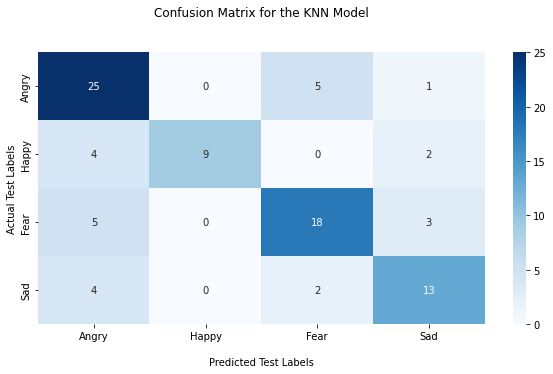

In [ ]:
model_confusion_matrix=confusion_matrix(y_test,knn_predictions,labels=y_test.unique())
plt.figure(figsize=(10,5))
ax = sns.heatmap(model_confusion_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix for the KNN Model\n\n')
ax.set_xlabel('\nPredicted Test Labels',fontsize=10)
ax.set_ylabel('Actual Test Labels',fontsize=10)
ax.xaxis.set_ticklabels(y_test.unique())
ax.yaxis.set_ticklabels(y_test.unique())
plt.show()

SVM Confusion Matrix

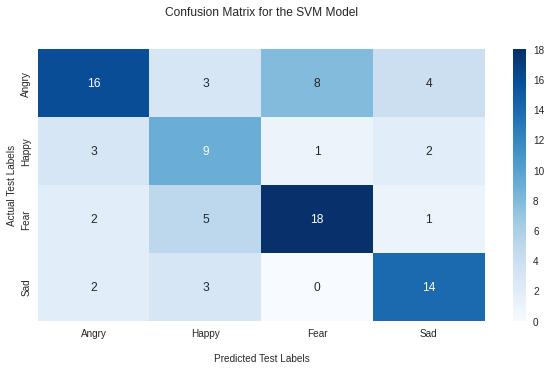

In [ ]:
model_confusion_matrix=confusion_matrix(y_test,svm_predictions,labels=y_test.unique())
plt.figure(figsize=(10,5))
ax = sns.heatmap(model_confusion_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix for the SVM Model\n\n')
ax.set_xlabel('\nPredicted Test Labels',fontsize=10)
ax.set_ylabel('Actual Test Labels',fontsize=10)
ax.xaxis.set_ticklabels(y_test.unique())
ax.yaxis.set_ticklabels(y_test.unique())
plt.show()

RF Confusion Matrix

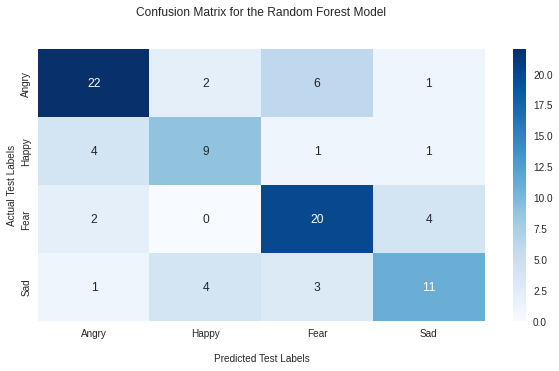

In [ ]:
model_confusion_matrix=confusion_matrix(y_test,rf_predictions,labels=y_test.unique())
plt.figure(figsize=(10,5))
ax = sns.heatmap(model_confusion_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix for the Random Forest Model\n\n')
ax.set_xlabel('\nPredicted Test Labels',fontsize=10)
ax.set_ylabel('Actual Test Labels',fontsize=10)
ax.xaxis.set_ticklabels(y_test.unique())
ax.yaxis.set_ticklabels(y_test.unique())
plt.show()

MLP Confusion Matrix

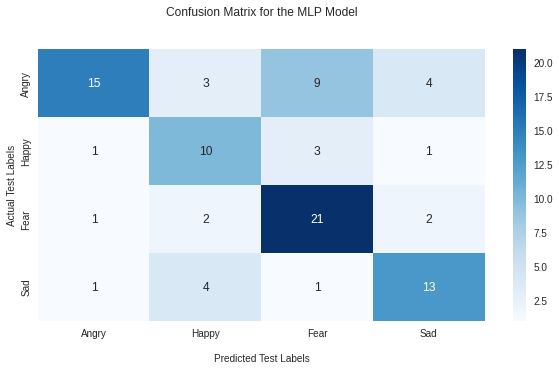

In [ ]:
model_confusion_matrix=confusion_matrix(y_test,clf_pred,labels=y_test.unique())
plt.figure(figsize=(10,5))
ax = sns.heatmap(model_confusion_matrix, annot=True, cmap='Blues')
ax.set_title('Confusion Matrix for the MLP Model\n\n')
ax.set_xlabel('\nPredicted Test Labels',fontsize=10)
ax.set_ylabel('Actual Test Labels',fontsize=10)
ax.xaxis.set_ticklabels(y_test.unique())
ax.yaxis.set_ticklabels(y_test.unique())
plt.show()

**ROC vs PRC**

**ROC** - The Receiver Operating Charecterisitic Curve provides the measurement of True Positive Rate vs False Positive Rate. The ROC curve performs good for balanced data set. Since the robot data used is an unbalanced data set, it can be misleading to use only the ROC curve as an evaluation metric for the models.

Hence PRC is used along with ROC

**PRC** - Precision – Recall Curve plots specificity vs sensitivity of a model. PRC takes into account the minority labels and gives a better performance identification which helps in fine tuning the models even better. 

Installing yellowbrick library for ROC and PRC curve

In [ ]:
!pip install yellowbrick

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve

ROC and PRC Curve for KNN

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  "X does not have valid feature names, but"


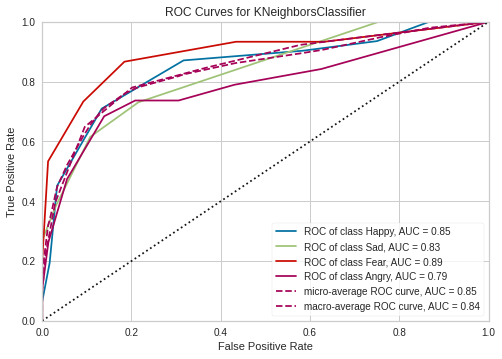

In [ ]:
visualizer = ROCAUC(knn_model,classes=['Happy','Sad','Fear','Angry'])
visualizer.fit(x_train,y_train)
visualizer.score(x_test,y_test)
visualizer.show()

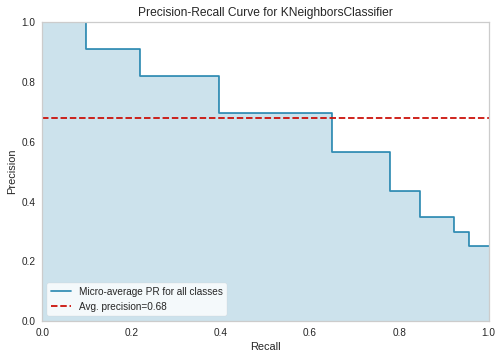

In [ ]:
visualizer = PrecisionRecallCurve(knn_model,classes=['Happy','Sad','Fear','Angry'])
visualizer.fit(x_train,y_train)
visualizer.score(x_test,y_test)
visualizer.show()

ROC and PRC for SVM model

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


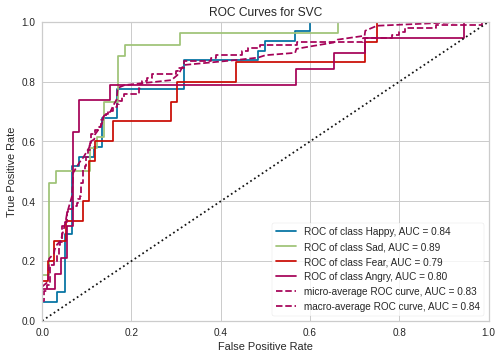

In [ ]:
svm_visualizer = ROCAUC(svm_model,classes=['Happy','Sad','Fear','Angry'])
svm_visualizer.fit(x_train,y_train)
svm_visualizer.score(x_test,y_test)
svm_visualizer.show()

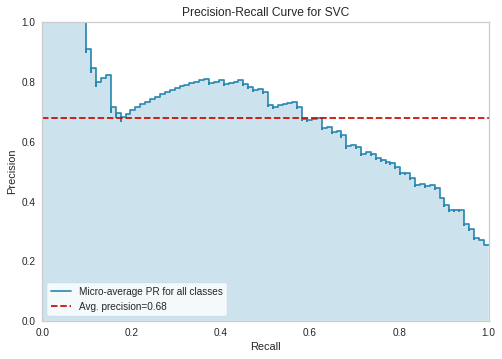

In [ ]:
svm_visualizer = PrecisionRecallCurve(svm_model,classes=['Happy','Sad','Fear','Angry'])
svm_visualizer.fit(x_train,y_train)
svm_visualizer.score(x_test,y_test)
svm_visualizer.show()

ROC and PRC curve for RF model

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  "X does not have valid feature names, but"


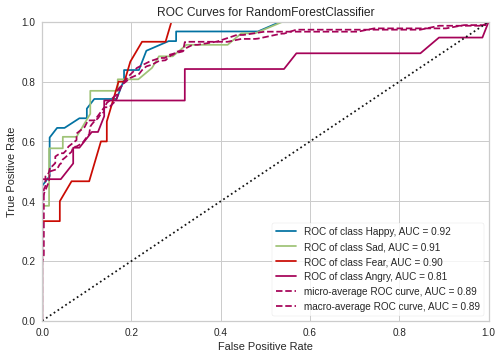

In [ ]:
rf_visualizer = ROCAUC(rf_model,classes=['Happy','Sad','Fear','Angry'])
rf_visualizer.fit(x_train,y_train)
rf_visualizer.score(x_test,y_test)
rf_visualizer.show()

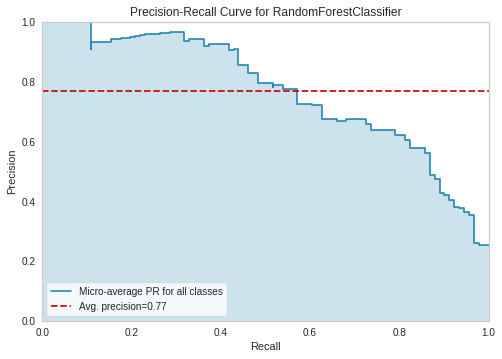

In [ ]:
rf_visualizer = PrecisionRecallCurve(rf_model,classes=['Happy','Sad','Fear','Angry'])
rf_visualizer.fit(x_train,y_train)
rf_visualizer.score(x_test,y_test)
rf_visualizer.show()

ROC and PRC curve for MLP model

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MLPClassifier was fitted with feature names
  "X does not have valid feature names, but"


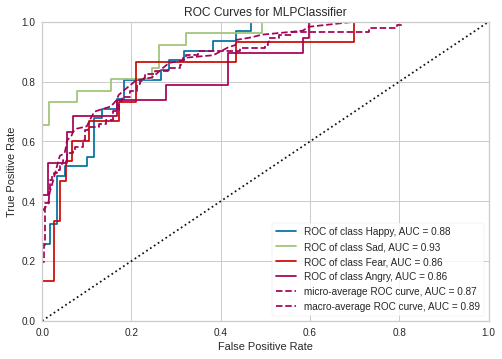

In [ ]:
mlp_visualizer = ROCAUC(clf,classes=['Happy','Sad','Fear','Angry'])
mlp_visualizer.fit(x_train,y_train)
mlp_visualizer.score(x_test,y_test)
mlp_visualizer.show()

Iteration 1, loss = 0.68707675
Iteration 2, loss = 0.63009966
Iteration 3, loss = 0.62879629
Iteration 4, loss = 0.61043301
Iteration 5, loss = 0.59878651
Iteration 6, loss = 0.58880830
Iteration 7, loss = 0.57993998
Iteration 8, loss = 0.59704312
Iteration 9, loss = 0.56873655
Iteration 10, loss = 0.56589191
Iteration 11, loss = 0.55447258
Iteration 12, loss = 0.55054783
Iteration 13, loss = 0.54251642
Iteration 14, loss = 0.54087072
Iteration 15, loss = 0.53851744
Iteration 16, loss = 0.52736596
Iteration 17, loss = 0.52723367
Iteration 18, loss = 0.52095878
Iteration 19, loss = 0.51058934
Iteration 20, loss = 0.49634833
Iteration 21, loss = 0.49669165
Iteration 22, loss = 0.50597661
Iteration 23, loss = 0.48227060
Iteration 24, loss = 0.47414199
Iteration 25, loss = 0.46947254
Iteration 26, loss = 0.45430236
Iteration 27, loss = 0.44592083
Iteration 28, loss = 0.46244335
Iteration 29, loss = 0.47019944
Iteration 30, loss = 0.45495435
Iteration 31, loss = 0.43666818
Iteration 32, los

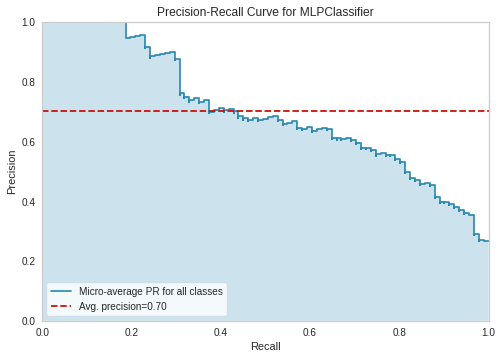

In [ ]:
mlp_visualizer = PrecisionRecallCurve(clf,classes=['Happy','Sad','Fear','Angry'])
mlp_visualizer.fit(x_train,y_train)
mlp_visualizer.score(x_test,y_test)
mlp_visualizer.show()

The ROC and PRC scores for the models are as follows:

<table width="200" height="150">
  <thead>
    <tr>
      <th>Model</th>
      <th>ROC</th>
      <th>PRC</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>KNN</td>
      <td>0.85</td>
      <td>0.68</td>
    </tr>
    <tr>
      <td>RF</td>
      <td>0.89</td>
      <td>0.77</td>
    </tr>
    <tr>
      <td>MLP</td>
      <td>0.87</td>
      <td>0.70</td>
    </tr>
    <tr>
      <td>SVM</td>
      <td>0.83</td>
      <td>0.68</td>
    </tr>
  </tbody>
</table>




From the above evaluations, it can be seen that the KNN model and the Random Forest model performed better than the SVM and MLP model for the training and test data set.

Finetuning the MLP model can result in much better accuracy with the help of large data sets.

This project sets ground work for future research in the field of emotion classification with tele-operated robots which will be very useful in the field of surgeries and military operations.

With the information of emotion, the security aspects of using robots in this field can also be increased like, the robot can be trained to stop functioning, when negative emotions such as anger or fear are being conveyed by the human operator. This is very vital in the field of surgies and bomb disposals.